# SN Like candidates in the last 4 days
### Ken Smith
Get supernova candidates ingested into Lasair within the last 14 days.  This notebook will use the Lasair client code, except for acquisiton of the user token.

Demonstrates usage of:
* /query/
* /objects/

### Python (3 only) requirements - pip install
lasair, requests

In [ ]:
!pip install lasair

  Created wheel for lasair: filename=lasair-0.0.1-cp37-none-any.whl size=5400 sha256=00e82630ba86e0a7ba2dace03b925a39e56191cac6800901d77034b9626cceac
  Stored in directory: /root/.cache/pip/wheels/90/14/ca/ebc366bda99df15e2f2a285ad518e6f54e586f9e493a761c8a
Successfully built lasair


### Grab my Lasair API token
Get your token before you start.  Change the cell below to enter your own credentials, or better still, set the last line of this cell to be your token ID.  You can also collect your token this way

```bash
curl --data "username=myusername&password=***********" https://lasair-ztf.lsst.ac.uk/api/auth-token/
```
You should get the following response:
```json
{"token":"4b762569bb349bd8d60f1bc7da3f39dbfaefff9a"}
```
We can use this token temporarily, but note that this test token will only allow a very small number of requests per hour!  Hence it may be disabled when you come to test this code.

In [ ]:
from astropy.time import Time
import matplotlib.pyplot as plt

from lasair import LasairError, lasair_client as lasair
import requests

# What is my Lasair API Key?
# THIS ACCOUNT IS TEMPORARY AND WILL BE DELETED AFTER THE WORKSHOP

token = "4b762569bb349bd8d60f1bc7da3f39dbfaefff9a"

### Make an SQL query
Note that the database is not very old - a few months.  (It's very much a prototype system, which may be destroyed and rebuilt at a moment's notice.)  Hence there will be no data older than 2021 in this system.

In [ ]:
# Get the objectId, coordinates, mjdmin, mjdmax, min r mag, most recent r mag
# sherlock designation, and a crude star / galaxy score (based on dist from PS1
# object and star/galaxy score of closest PS1 source)
selected = """
objects.objectId,
objects.ramean,
objects.decmean,
objects.jdmin - 2400000.5 AS mjdmin,
objects.jdmax - 2400000.5 AS mjdmax,
objects.magrmin,
objects.rmag,
sherlock_classifications.classification,
IF(objects.distpsnr1 < 2 AND objects.sgscore1 > 0.49, "PS1_star", "Not_PS1_star") score
"""

# Join objects and sherlock_classifications
tables = 'objects,sherlock_classifications'

# The object should be less than 4 days old, classified by sherlock as SN or
# UNCLEAR, number of detections is 3 or more, latest g-mag brighter than 20
# (for ePESSTO+ followup), has 2 or more positive flux detections and has a name
# with a 21 designation.
conditions = """
objects.jdmin > JDNOW() - 14.0
AND sherlock_classifications.classification NOT IN ("VS" , "AGN", "CV", "BS")
AND objects.ncand >= 3
AND objects.gmag < 20
AND objects.ncandgp > 1
AND objects.objectId like 'ZTF21%'
ORDER BY score, objectId DESC
"""

L = lasair(token, endpoint = "https://lasair-ztf.lsst.ac.uk/api")
try:
    results = L.query(selected, tables, conditions, limit = 10)
except LasairError as e:
    print(e)


In [ ]:
for row in results:
    print(row['objectId'],
          "%.5f" % row['ramean'],
          "%.5f" % row['decmean'],
          "%.5f" % row['mjdmin'],
          "%.5f" % row['mjdmax'],
          "%.2f" % row['magrmin'],
          "%.2f" % row['rmag'],
          row['classification'],
          row['score'])


ZTF21aaxbidh 309.64357 5.42355 59325.44314 59329.47596 17.28 17.46 SN Not_PS1_star
ZTF21aaxbgzh 316.70520 5.78596 59323.47260 59325.48307 19.48 19.48 SN Not_PS1_star
ZTF21aaxbgul 304.52593 -2.18042 59322.45569 59329.47690 18.96 18.96 SN Not_PS1_star
ZTF21aawzkdr 230.70215 31.16429 59323.30124 59329.34016 18.99 18.99 SN Not_PS1_star
ZTF21aawyyha 204.99064 67.56791 59325.28204 59329.34368 18.65 18.65 SN Not_PS1_star
ZTF21aawxqll 130.07489 44.52969 59319.24688 59329.21390 19.74 19.74 NT Not_PS1_star
ZTF21aawxalc 121.17564 -13.36846 59325.16015 59329.19494 17.58 17.58 UNCLEAR Not_PS1_star
ZTF21aawtewf 235.83786 42.15368 59322.34898 59328.32832 19.37 19.37 SN Not_PS1_star
ZTF21aawtazf 248.98476 18.08286 59324.38177 59328.36094 19.06 19.06 SN Not_PS1_star
ZTF21aawsowp 278.40339 22.15047 59322.43565 59328.40609 19.75 19.77 SN Not_PS1_star


### Grab the lightcurves using the objects API

https://lasair-iris.roe.ac.uk/object/ZTF21aaxbidh has no TNS info in Lasair yet
https://lasair-iris.roe.ac.uk/object/ZTF21aaxbgzh AT2021kje
https://lasair-iris.roe.ac.uk/object/ZTF21aaxbgul AT2021kjf
https://lasair-iris.roe.ac.uk/object/ZTF21aawzkdr AT2021kji
https://lasair-iris.roe.ac.uk/object/ZTF21aawyyha AT2021kjj
https://lasair-iris.roe.ac.uk/object/ZTF21aawxqll AT2021kjk
https://lasair-iris.roe.ac.uk/object/ZTF21aawxalc has no TNS info in Lasair yet
https://lasair-iris.roe.ac.uk/object/ZTF21aawtewf AT2021kgu
https://lasair-iris.roe.ac.uk/object/ZTF21aawtazf AT2021kkz
https://lasair-iris.roe.ac.uk/object/ZTF21aawsowp AT2021khb


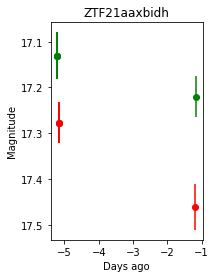

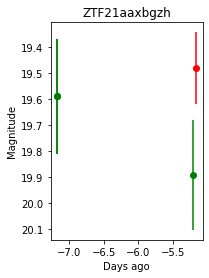

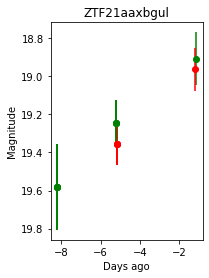

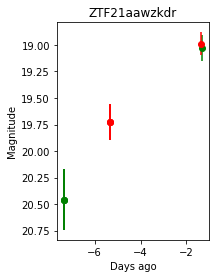

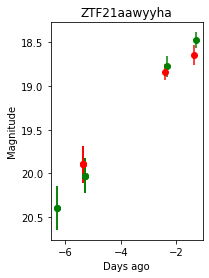

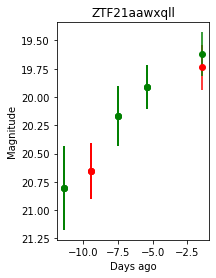

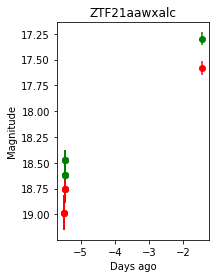

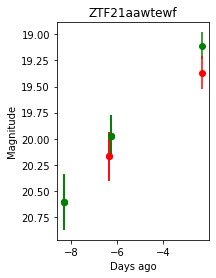

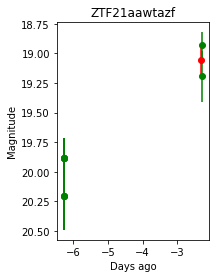

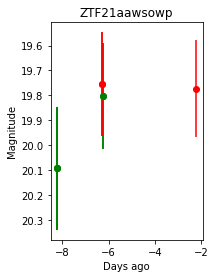

In [ ]:
objectList = [row['objectId'] for row in results]
response = L.objects(objectList)

# create an dictionary of lightcurves

lcsDict = {}
for obj in response:
    lcsDict[obj['objectId']] = {'candidates': obj['candidates']}

cols = {1:'g',2:'r'}

now = Time.now().jd

for obj in response:
        try:
            print ('https://lasair-ztf.lsst.ac.uk/object/%s %s%s' % (obj['objectId'], obj['TNS']['tns_prefix'], obj['TNS']['tns_name']))
        except KeyError as e:
            print ('https://lasair-ztf.lsst.ac.uk/object/%s %s' % (obj['objectId'], "has no TNS info in Lasair yet"))
        plt.figure()
        plt.subplot(121)
        for i in lcsDict[obj['objectId']]['candidates']:
            if 'isdiffpos' in i:
                if i['isdiffpos']=='t':
                    plt.errorbar(i['jd']-now,i['magpsf'],i['sigmapsf'],fmt='o',color=cols[i['fid']])
        plt.gca().invert_yaxis()
        plt.ylabel('Magnitude')
        plt.xlabel('Days ago')
        plt.title(obj['objectId'])
